In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# numericalization
from collections import Counter

# preprocessing
import re
import nltk
from nltk.corpus import stopwords # will give an altered version later cuz the default isn't great
from string import punctuation
# from textblob import TextBlob
from collections import Counter
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

# modeling
from sklearn.model_selection import train_test_split

# neural nets
import tensorflow as tf
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import Sequential, Input, optimizers
from keras.optimizers import Adam
from transformers import (
    RobertaForSequenceClassification, RobertaTokenizer, BertForSequenceClassification, 
    BertTokenizer, AutoModelForSequenceClassification, AutoTokenizer, AdamW
)

pd.set_option('display.max_columns', 500)
title_fontsize = 15

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/setone/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/setone/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/setone/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/setone/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/Users/setone/miniforge3/envs/tf-gpu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import plotly as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [46]:
df = pd.read_csv('./data/cleaned_up_data/all_stock_sentiment.csv').iloc[:, 1:].drop_duplicates()
stocks = pd.read_csv('./data/scraped_stocks/scraped_stock_2015_2022.csv').iloc[:, 1:]
df.Date = pd.to_datetime(df.Date).dt.year
stocks.Date = pd.to_datetime(stocks.Date).dt.date

In [68]:
dff[dff.Date == 2020].sort_values('Content', ascending=False)[['ticker', 'Content']]

,ticker,Content
116,DIS,1288
121,META,1145
126,PYPL,529
124,NIO,485
112,AAPL,374
122,MSFT,338
120,KO,316
115,COST,289
113,AMZN,257
130,ZS,241


In [75]:
pd.pivot(dff, index=['ticker'], columns=['Date'], values=['Content']).to_csv('./data/content.csv')

In [73]:
dframe = dff[dff.Date == 2019]

,Date,ticker,Content,sentiment
0,2014,BX,1,1
1,2014,COST,1,1
2,2014,CRM,1,1
3,2014,DIS,2,2
4,2014,KO,8,8
...,...,...,...,...
173,2022,TSLA,26314,26314
174,2022,TSM,8112,8112
175,2022,VZ,32,32
176,2022,XPEV,44,44


In [67]:
dff[dff.Date == 2019].sort_values('Content', ascending=False)[['ticker', 'Content']]

,ticker,Content
108,TSLA,325034
89,AAPL,186868
91,AMZN,90536
98,GOOG,62196
102,MSFT,35067
97,F,14090
90,AMD,14081
109,TSM,14054
106,PG,4011
92,BA,2566


In [56]:
dff = df.groupby(['Date', 'ticker'], as_index=False).count()
dff[dff.Date == 2019]

,Date,ticker,Content,sentiment
89,2019,AAPL,186868,186868
90,2019,AMD,14081,14081
91,2019,AMZN,90536,90536
92,2019,BA,2566,2566
93,2019,BX,229,229
94,2019,COST,261,261
95,2019,CRM,1832,1832
96,2019,DIS,1501,1501
97,2019,F,14090,14090
98,2019,GOOG,62196,62196


In [4]:
df['label'] = df['sentiment'].apply(lambda x: 'bullish' if x > 0.5 else 'bearish')
df = df.groupby(['Date', 'ticker', 'label'], as_index=False)['sentiment'].count()

df = df.merge(df.groupby(['Date', 'ticker'], as_index=False)['sentiment'].mean().rename(
    columns={'sentiment': 'sentiment_avg'}))

df.columns = ['Date', 'Stock Name', 'sentiment', 'sentiment_count', 'sentiment_avg']

df = df.merge(stocks)

In [14]:
def update_line_chart(company, df):

    if company == 'All':
        # change this when you're done with testing
        company = 'AAPL'
        
    data = df[df['Stock Name'] == company]

#     df_comp = df[df['company'] == company]
#     df_comp = df_comp.groupby('date', as_index=False)['sentiment'].mean()
    data['SMA30'] = data['sentiment_avg'].rolling(30).mean()
    data['SMA90'] = data['sentiment_avg'].rolling(90).mean()
    
    data['label'] = np.where(data['SMA30']>data['SMA90'], 1, 0)
    data['group'] = data['label'].ne(data['label'].shift()).cumsum()
#     df_comp = df_comp.rename(columns={'date': 'Date'})

#     stock_comp = stocks_df[stocks_df['Stock Name'] == company]
#     stock_comp['Date'] = pd.to_datetime(stock_comp['Date'])
#     stock_comp['Date'] = stock_comp['Date'].dt.date
#     combined = pd.merge(df_comp, stock_comp, how='left', on="Date")
    #data = combined.to_dict("records")
    # Create figure with secondary y-axis
    fig = make_subplots(rows=4, cols=1, specs=[[{"secondary_y": True, 'rowspan': 2}], 
                                               [None],
                                               [{'rowspan': 1}],
                                               [{'rowspan': 1}]], vertical_spacing=0.05)

    # Add traces
    fig.add_trace(
        go.Candlestick(x=data['Date'],
                    open=data['Open'],
                    high=data['High'],
                    low=data['Low'],
                    close=data['Close'],
                    name=""),
        secondary_y=True,
    )
    
    combined1 = data.copy()

    # split data into chunks where averages cross each other
#     df['label'] = np.where(df['SMA30']>df['SMA90'], 1, 0)
#     df['group'] = df['label'].ne(df['label'].shift()).cumsum()
    combined = data.groupby('group')
    combined_s = []
    for _, dta in combined:
        combined_s.append(dta)

    # custom function to set fill color
    def fillcol(label):
        if label >= 1:
            return 'rgba(0,250,0,0.4)'
        else:
            return 'rgba(250,0,0,0.4)'

    for df in combined_s:
        fig.add_traces(go.Scatter(x=df.Date, y = df.SMA30,
                                line = dict(color='rgba(0,0,0,0)'),
                                hoverinfo='skip'
                                ))
        
        fig.add_traces(go.Scatter(x=df.Date, y = df.SMA90,
                                line = dict(color='rgba(0,0,0,0)'),
                                fill='tonexty', 
                                fillcolor = fillcol(df['label'].iloc[0]),
                                hoverinfo='skip'
                                ))

    # include averages
    fig.add_traces(go.Scatter(x=combined1.Date, y = combined1.SMA30,
                            line = dict(color = 'green', width=1), 
                            name='MA30', hoverinfo='skip'
                            ))

    fig.add_traces(go.Scatter(x=combined1.Date, y = combined1.SMA90,
                            line = dict(color = 'red', width=1), 
                            name='MA90', hoverinfo='skip'
                            ))
#     df2 = combined_df[combined_df['company'] == company]
#     comp_group = df2.groupby(by=["date", "sentiment"], as_index=False).agg(
#         count_col=pd.NamedAgg(column="sentiment", aggfunc="count"))

    # subplot 1: sentiment volume
    trace1 = go.Bar(
        x = data['Date'],
        y = data[data['sentiment'] == 'bullish']['sentiment_count'],
#         y = comp_group[comp_group['sentiment'] == 1]['count_col'],
        name='Bullish',
        marker_color='green',
        marker_line_width=0
        )
    trace2 = go.Bar(
        x = data['Date'],
        y = data[data['sentiment'] == 'bearish']['sentiment_count'],
        name='Bearish',
        marker_color='red',
        marker_line_width=0
        )
    fig.add_traces([trace1, trace2], rows=3, cols=1)
    fig.update_layout(barmode = 'stack')

    # subplot 2: stock volume
    stock_vol = go.Bar(
        x = data['Date'],
        y = data['Volume'],
        name = 'Volume',
        marker_color='blue')
    fig.add_trace(stock_vol, row=4, col=1)

    # Set title
    fig.layout.update(title=f'{company} Stock Price v. Sentiment',
                     showlegend=True, hovermode='closest')

    # Set x-axis title
    fig.update_xaxes(title_text="Date", row=1, col=1)
    fig.update_xaxes(title_text="Date", row=3, col=1)
    fig.update_xaxes(title_text="Date", row=4, col=1)
    fig.update_layout(xaxis_rangeslider_visible=False)
    # Set y-axes titles
    fig.update_yaxes(title_text="Stock Price", secondary_y=True, row=1, col=1)
    fig.update_yaxes(title_text="Stock Sentiment", secondary_y=False, row=1, col=1)
    fig.update_yaxes(title_text="Sentiment Volume", secondary_y=False, row=3, col=1)
    fig.update_yaxes(title_font=dict(size=10), secondary_y=False, row=3, col=1)
    fig.update_yaxes(title_text="Stock Volume", secondary_y=False, row=4, col=1)
    fig.update_yaxes(title_font=dict(size=10), secondary_y=False, row=4, col=1)

    # set y-axes subplots to display only min/max
    # fig.update_layout(yaxis=dict(tickmode='linear', nticks=2, 
    #     range=[min(combined['Volume']), max(combined['Volume'])], row=4, col=1))
    
    fig.update_layout(
    # width=500,
    # height=850,
    showlegend=False,
    hovermode='x unified', 
    template='plotly_white',
    legend=dict(
    x=0,
    y=1.05,
    traceorder="normal",
    font=dict(
        family="sans-serif",
        size=12,
        color="black"
    )))
    fig.update_traces(xaxis='x1')
    return fig

In [76]:
update_line_chart('META', df)

KeyError: 'Stock Name'

In [514]:
data = df[df['Stock Name'] == company]
data['SMA30'] = data['sentiment_avg'].rolling(30).mean()
data['SMA90'] = data['sentiment_avg'].rolling(90).mean()

data['label'] = np.where(data['SMA30']>data['SMA90'], 1, 0)
data['group'] = data['label'].ne(data['label'].shift()).cumsum()

data

,Date,Stock Name,sentiment,sentiment_count,sentiment_avg,Open,High,Low,Close,Adj Close,Volume,SMA30,SMA90,label,group
37103,2022-09-22,AAPL,bearish,2,2.0,152.380005,154.470001,150.910004,152.740005,152.487045,86652500,NaN,NaN,0,1
37104,2022-09-22,AAPL,bullish,2,2.0,152.380005,154.470001,150.910004,152.740005,152.487045,86652500,NaN,NaN,0,1
37125,2022-09-23,AAPL,bearish,4,5.0,151.190002,151.470001,148.559998,150.429993,150.180862,96029900,NaN,NaN,0,1
37126,2022-09-23,AAPL,bullish,6,5.0,151.190002,151.470001,148.559998,150.429993,150.180862,96029900,NaN,NaN,0,1
37142,2022-09-26,AAPL,bearish,3,5.5,149.660004,153.770004,149.639999,150.770004,150.520309,93339400,NaN,NaN,0,1
37143,2022-09-26,AAPL,bullish,8,5.5,149.660004,153.770004,149.639999,150.770004,150.520309,93339400,NaN,NaN,0,1
37162,2022-09-27,AAPL,bearish,1,2.0,152.740005,154.720001,149.949997,151.759995,151.508667,84442700,NaN,NaN,0,1
37163,2022-09-27,AAPL,bullish,3,2.0,152.740005,154.720001,149.949997,151.759995,151.508667,84442700,NaN,NaN,0,1
37179,2022-09-28,AAPL,bearish,37,30.5,147.639999,150.639999,144.839996,149.839996,149.591843,146691400,NaN,NaN,0,1
37180,2022-09-28,AAPL,bullish,24,30.5,147.639999,150.639999,144.839996,149.839996,149.591843,146691400,NaN,NaN,0,1


In [29]:
dff = df[df['Stock Name'] == 'AAPL']
x = dff['Date']
y1 = dff[dff['sentiment'] == 'bullish']['sentiment_count']
y2 = dff[dff['sentiment'] == 'bearish']['sentiment_count']

In [31]:
dff

,Date,Stock Name,sentiment,sentiment_count,sentiment_avg,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,AAPL,bearish,248,404.5,27.847500,27.860001,26.837500,27.332500,24.603210,212818400
1,2015-01-02,AAPL,bullish,561,404.5,27.847500,27.860001,26.837500,27.332500,24.603210,212818400
15,2015-01-05,AAPL,bearish,306,445.5,27.072500,27.162500,26.352501,26.562500,23.910091,257142000
16,2015-01-05,AAPL,bullish,585,445.5,27.072500,27.162500,26.352501,26.562500,23.910091,257142000
32,2015-01-06,AAPL,bearish,251,458.5,26.635000,26.857500,26.157499,26.565001,23.912342,263188400
...,...,...,...,...,...,...,...,...,...,...,...
37143,2022-09-26,AAPL,bullish,8,5.5,149.660004,153.770004,149.639999,150.770004,150.520309,93339400
37162,2022-09-27,AAPL,bearish,1,2.0,152.740005,154.720001,149.949997,151.759995,151.508667,84442700
37163,2022-09-27,AAPL,bullish,3,2.0,152.740005,154.720001,149.949997,151.759995,151.508667,84442700
37179,2022-09-28,AAPL,bearish,37,30.5,147.639999,150.639999,144.839996,149.839996,149.591843,146691400


<AxesSubplot: xlabel='Date', ylabel='sentiment_count'>

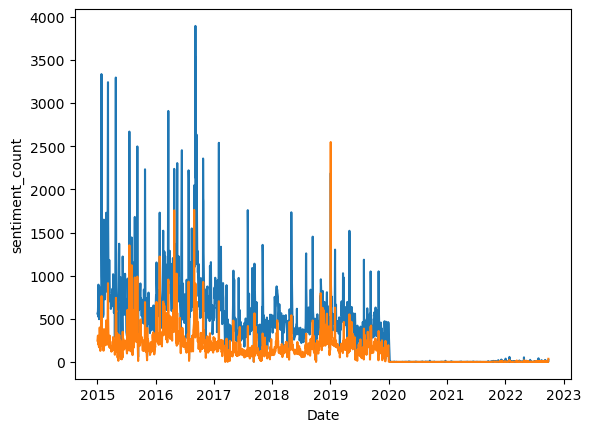

In [30]:
sns.lineplot(x=x, y=y1)
sns.lineplot(x=x, y=y2)

In [18]:
go.Bar(
        x = data['Date'],
        y = data[data['sentiment'] == 'bullish']['sentiment_count'],
#         y = comp_group[comp_group['sentiment'] == 1]['count_col'],
        name='Bullish',
        marker_color='green',
        marker_line_width=0
        )

NameError: name 'data' is not defined

In [249]:
df_sent

,Date,ticker,sentiment,label
0,2014-12-31,BX,0.018023,bearish
1,2014-12-31,COST,0.987811,bullish
2,2014-12-31,CRM,0.998855,bullish
3,2014-12-31,DIS,0.998835,bullish
4,2014-12-31,KO,0.386977,bearish
...,...,...,...,...
33043,2022-09-29,NFLX,0.666051,bullish
33044,2022-09-29,NIO,0.996589,bullish
33045,2022-09-29,PYPL,0.008032,bearish
33046,2022-09-29,TSLA,0.707093,bullish


In [204]:
df2.Date

35082   2015-01-02
35083   2015-01-05
35084   2015-01-06
35085   2015-01-07
35086   2015-01-08
           ...    
37026   2022-09-22
37027   2022-09-23
37028   2022-09-26
37029   2022-09-27
37030   2022-09-28
Name: Date, Length: 1949, dtype: datetime64[ns]

In [219]:
AAPL

,Date,ticker,sentiment,label,Open,High,Low,Close,Adj Close,Volume,Stock Name,color
0,2015-01-02,AAPL,0.688692,Bullish,27.847500,27.860001,26.837500,27.332500,24.603210,212818400,AAPL,green
1,2015-01-05,AAPL,0.660067,Bullish,27.072500,27.162500,26.352501,26.562500,23.910091,257142000,AAPL,green
2,2015-01-06,AAPL,0.723693,Bullish,26.635000,26.857500,26.157499,26.565001,23.912342,263188400,AAPL,green
3,2015-01-07,AAPL,0.717626,Bullish,26.799999,27.049999,26.674999,26.937500,24.247650,160423600,AAPL,green
4,2015-01-08,AAPL,0.779750,Bullish,27.307501,28.037500,27.174999,27.972500,25.179293,237458000,AAPL,green
...,...,...,...,...,...,...,...,...,...,...,...,...
1721,2022-09-22,AAPL,0.501282,Bullish,152.380005,154.470001,150.910004,152.740005,152.487045,86652500,AAPL,green
1722,2022-09-23,AAPL,0.586537,Bullish,151.190002,151.470001,148.559998,150.429993,150.180862,96029900,AAPL,green
1723,2022-09-26,AAPL,0.680350,Bullish,149.660004,153.770004,149.639999,150.770004,150.520309,93339400,AAPL,green
1724,2022-09-27,AAPL,0.746283,Bullish,152.740005,154.720001,149.949997,151.759995,151.508667,84442700,AAPL,green


In [221]:
AAPL

,Date,ticker,sentiment,label,Open,High,Low,Close,Adj Close,Volume,Stock Name,color
0,2015-01-02,AAPL,0.688692,Bullish,27.847500,27.860001,26.837500,27.332500,24.603210,212818400,AAPL,green
1,2015-01-05,AAPL,0.660067,Bullish,27.072500,27.162500,26.352501,26.562500,23.910091,257142000,AAPL,green
2,2015-01-06,AAPL,0.723693,Bullish,26.635000,26.857500,26.157499,26.565001,23.912342,263188400,AAPL,green
3,2015-01-07,AAPL,0.717626,Bullish,26.799999,27.049999,26.674999,26.937500,24.247650,160423600,AAPL,green
4,2015-01-08,AAPL,0.779750,Bullish,27.307501,28.037500,27.174999,27.972500,25.179293,237458000,AAPL,green
...,...,...,...,...,...,...,...,...,...,...,...,...
1721,2022-09-22,AAPL,0.501282,Bullish,152.380005,154.470001,150.910004,152.740005,152.487045,86652500,AAPL,green
1722,2022-09-23,AAPL,0.586537,Bullish,151.190002,151.470001,148.559998,150.429993,150.180862,96029900,AAPL,green
1723,2022-09-26,AAPL,0.680350,Bullish,149.660004,153.770004,149.639999,150.770004,150.520309,93339400,AAPL,green
1724,2022-09-27,AAPL,0.746283,Bullish,152.740005,154.720001,149.949997,151.759995,151.508667,84442700,AAPL,green


In [222]:
for tick in df_sent['ticker'].unique():
    df1 = df_sent[df_sent['ticker'] == tick]
    df1['Date'] = pd.to_datetime(df1['Date'])
    df2 = stocks_df[stocks_df['Stock Name'] == tick]
    
    globals()[tick] = pd.merge(df1, df2, on='Date')
    globals()[tick]['color'] = globals()[tick]['sentiment'].apply(lambda x: 'green' if x>0.6 else 'red' if x<0.4 else 'orange')
    globals()[tick]['label'] = globals()[tick]['sentiment'].apply(lambda x: 'Bullish' if x>0.6 else 'Bearish' if x<0.4 else 'Neutral')

/var/folders/qp/1k1ym6rd1z34yt05vjspksl40000gn/T/ipykernel_75800/584812570.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/qp/1k1ym6rd1z34yt05vjspksl40000gn/T/ipykernel_75800/584812570.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/qp/1k1ym6rd1z34yt05vjspksl40000gn/T/ipykernel_75800/584812570.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [ ]:
# def update_line_chart(company, yrs):
# #     if analysis == [] or company is 'All':
# #         return {}, []

#     if company == 'All':
#         # change this when you're done with testing
#         df = globals()['AAPL'][globals()['AAPL'].Date.dt.year.between(yrs[0], yrs[1])]
#     else:
#         df = globals()[company][globals()[company].Date.dt.year.between(yrs[0], yrs[1])]

#     data = df.to_dict("records")

#     fig = make_subplots(
#         rows=3, cols=1,
#         specs=[[{'rowspan': 2}],
#             [None],
#             [{'rowspan': 1}]],
#         vertical_spacing=0.05)

#     stock = go.Scatter(x=df['Date'], y=df['Adj Close'], name="Adj. Close")
#     MA30 = go.Scatter(x=df['Date'], y=df['High'].rolling(window=30).mean(), name="30 day MA")
#     MA50 = go.Scatter(x=df['Date'], y=df['High'].rolling(window=50).mean(), name="50 day MA")
#     sentiment = go.Bar(x=df['Date'], y=df['sentiment'], name="Sentiment", marker=dict(color=df['color'], line=dict(width=0)), showlegend=False)
    
#     fig.append_trace(stock, row=1, col=1)
#     fig.append_trace(MA30, row=1, col=1)
#     fig.append_trace(MA50, row=1, col=1)
#     fig.append_trace(sentiment, row=3, col=1)

#     fig.update_yaxes(title_text='Stock Price', row=1, col=1)
#     fig.update_yaxes(title_text='Sentiment', row=3, col=1)
#     fig.update_yaxes(tickmode='array',
# #                  tickvals=[0, 0.5, 1],
#                  row=3, col=1)

#     fig.layout.update(title=f'{company} Stock Price v. Sentiment',
#                      height=600, width=850, showlegend=True, hovermode='closest')

#     fig.update_layout(
#         template='plotly_white',
#         hovermode='x unified', 
#         legend=dict(
#         x=0,
#         y=1.05,
#         traceorder="normal",
#         font=dict(
#             family="sans-serif",
#             size=12,
#             color="black"
#         )))
#     fig.update_traces(xaxis='x1')
    
#     return fig